In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import functional as F

# Загрузка MNIST

In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

In [3]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise()
])
data = datasets.MNIST('./', train=True, download=True, transform=transformer)
data_loader = DataLoader(data, batch_size=100, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 47985521.19it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72666882.92it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28455891.43it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4909930.09it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Автокодировщик полносвязной нейронной сети

In [ ]:
autoencoder_fc = nn.Sequential(
    # Энкодер
    nn.Linear(784, 300),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Linear(100, 20),
    nn.ReLU(),
    nn.Linear(20, 3),
    # Декодер
    nn.Linear(3, 20),
    nn.ReLU(),
    nn.Linear(20, 100),
    nn.ReLU(),
    nn.Linear(100, 300),
    nn.ReLU(),
    nn.Linear(300, 784),
    nn.Sigmoid()
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder_fc.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_fc.parameters(), lr=0.001)

In [ ]:
autoencoder_fc.train()
for epoch in range(5):
    total_loss = 0.0
    for data in data_loader:
        optimizer.zero_grad()
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        output = autoencoder_fc(img)
        loss = criterion(output, img)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Эпоха: {epoch+1}, Ошибка: {total_loss/len(data_loader)}')

Эпоха: 1, Ошибка: 1.0584327034155527
Эпоха: 2, Ошибка: 1.0434801024198532
Эпоха: 3, Ошибка: 1.0398159899314245
Эпоха: 4, Ошибка: 1.0376940375566484
Эпоха: 5, Ошибка: 1.0365689758459726


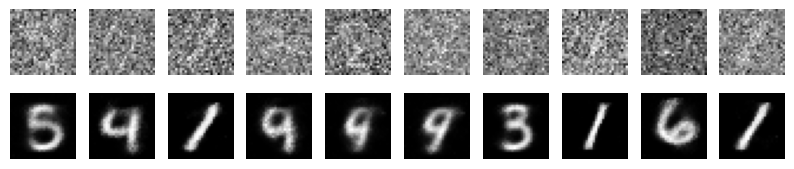

In [ ]:
autoencoder_fc.eval()
with torch.no_grad():
    dataiter = iter(data_loader)
    img, _ = next(dataiter)
    img = img.view(img.size(0), -1).to(device)
    output = autoencoder_fc(img)
    img = img.view(img.size(0), 1, 28, 28)
    output = output.view(output.size(0), 1, 28, 28)
    fig, ax = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        ax[0, i].imshow(img[i].cpu().numpy().squeeze(), cmap='gray')
        ax[1, i].imshow(output[i].cpu().numpy().squeeze(), cmap='gray')
        ax[0, i].axis('off')
        ax[1, i].axis('off')
    plt.show()

# Вариационный автокодировщик

In [ ]:
!unzip faces.zip -d faces_data

In [4]:
transformer = transforms.Compose([
    transforms.ToTensor(),
])
data = datasets.ImageFolder('/content/faces_data', transform=transformer)
data_loader = DataLoader(data, batch_size=50, shuffle=True)

In [5]:
iterator, _ = next(iter(data_loader))

In [6]:
iterator.shape

torch.Size([50, 3, 64, 64])

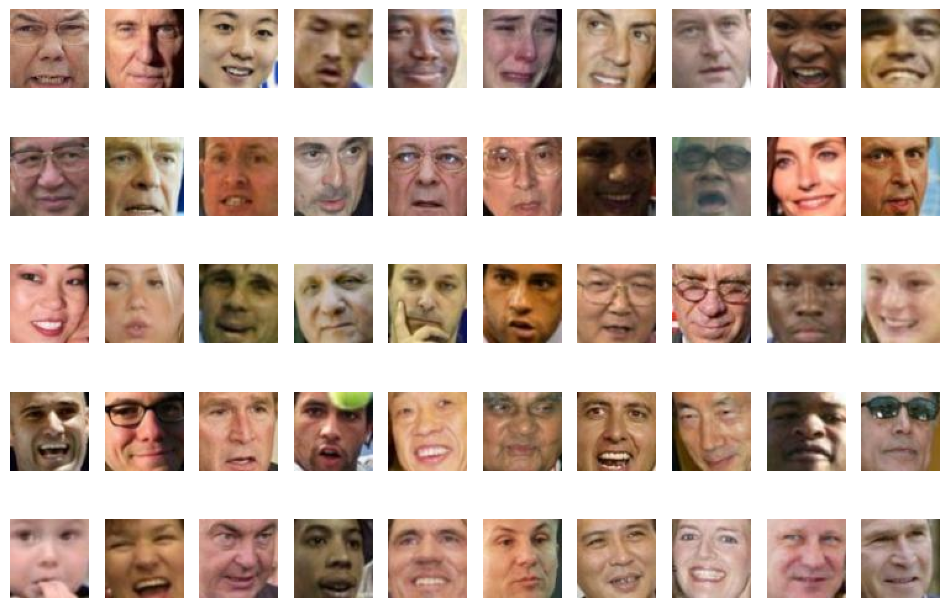

In [7]:
fig, axs = plt.subplots(5, 10, figsize=(12, 8))
axs = axs.flatten()
for i, ax in enumerate(axs):
  ax.axis('off')
  ax.imshow(iterator[i].permute(1, 2, 0))
plt.show()

In [25]:
class VAE(nn.Module):
    def __init__(self, nc=3, ndf=32, latent_dim=1024):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(ndf * 8 * 4 * 4, latent_dim * 2)
        )
        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, ndf * 8 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (ndf * 8, 4, 4)),
            nn.ConvTranspose2d(ndf * 8, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(ndf * 4, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(ndf * 2, ndf, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(ndf, nc, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        out = self.encoder(x)
        mu = out[:, :1024]
        logvar = out[:, 1024:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar, alpha=0.3):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return alpha * MSE + KLD

In [26]:
vae = VAE()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
vae.train()
for epoch in range(10):
    total_loss = 0.0
    for data in data_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        reconstructed_img, mu, logvar = vae(img)
        loss = loss_function(reconstructed_img, img, mu, logvar)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Эпоха: {epoch+1}, Средняя ошибка: {total_loss / len(data_loader)}')

Эпоха: 1, Средняя ошибка: 4623.200592386497
Эпоха: 2, Средняя ошибка: 3457.413596329599
Эпоха: 3, Средняя ошибка: 3331.506472029776
Эпоха: 4, Средняя ошибка: 3283.2109651385613
Эпоха: 5, Средняя ошибка: 3251.9500138192807
Эпоха: 6, Средняя ошибка: 3235.572008125737
Эпоха: 7, Средняя ошибка: 3220.7078668558374
Эпоха: 8, Средняя ошибка: 3200.962416163031
Эпоха: 9, Средняя ошибка: 3201.9331156028893
Эпоха: 10, Средняя ошибка: 3184.2674988944577


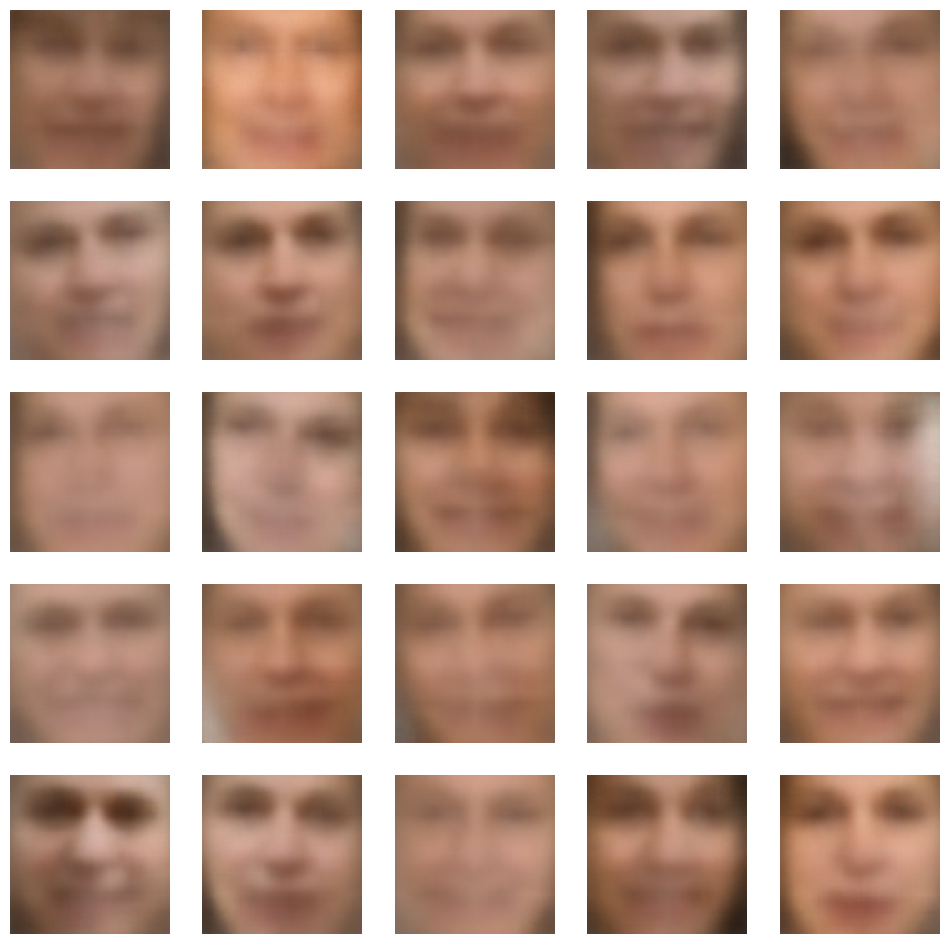

In [28]:
def generate_sample(vae, latent_dim, num_samples, device):
    vae.eval()
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        generated_data = vae.decode(z)
    return generated_data

generated_images = generate_sample(vae,1024, 25, device)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()
for i, img in enumerate(generated_images):
    axs[i].imshow(img.permute(1, 2, 0).cpu())
    axs[i].axis('off')
plt.show()